Image paths loaded: [['pictures/14-7-35\\20250618_143100.jpg', 'pictures/14-7-35\\20250618_143108.jpg', 'pictures/14-7-35\\20250618_143113.jpg', 'pictures/14-7-35\\20250618_143119.jpg', 'pictures/14-7-35\\20250618_143124.jpg', 'pictures/14-7-35\\20250618_143130.jpg', 'pictures/14-7-35\\20250618_143135.jpg', 'pictures/14-7-35\\20250618_143141.jpg', 'pictures/14-7-35\\20250618_143146.jpg', 'pictures/14-7-35\\20250618_143152.jpg', 'pictures/14-7-35\\20250618_143200.jpg', 'pictures/14-7-35\\20250618_143206.jpg', 'pictures/14-7-35\\20250618_143212.jpg', 'pictures/14-7-35\\20250618_143217.jpg', 'pictures/14-7-35\\20250618_143223.jpg', 'pictures/14-7-35\\20250618_143227.jpg', 'pictures/14-7-35\\20250618_143231.jpg', 'pictures/14-7-35\\20250618_143236.jpg', 'pictures/14-7-35\\20250618_143242.jpg', 'pictures/14-7-35\\20250618_143246.jpg'], ['pictures/15-7-18\\20250618_142208.jpg', 'pictures/15-7-18\\20250618_142216.jpg', 'pictures/15-7-18\\20250618_142222.jpg', 'pictures/15-7-18\\20250618_14223

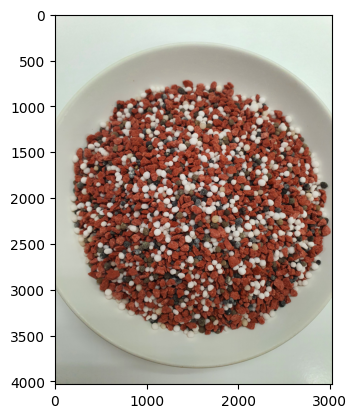

In [1]:
import cv2
import numpy as np
from segment_anything import sam_model_registry, SamPredictor
import torch
import os
import matplotlib.pyplot as plt

# === Load the image ===
img_path_list = []
folder_path_1 = "pictures/14-7-35"
folder_path_2 = "pictures/15-7-18"
folder_path_3 = "pictures/15-15-15"
folder_path_4 = "pictures/18-4-5"
for path in [folder_path_1, folder_path_2, folder_path_3, folder_path_4]:
    if not os.path.exists(path):
        raise FileNotFoundError(f"Folder {path} does not exist.")
    # Get all image paths from the folders
    image_path = [os.path.join(path, f) for f in os.listdir(path) if f.endswith('.jpg')]
    img_path_list.append(image_path)
print("Image paths loaded:", img_path_list)
print(len(img_path_list), "folders found with images.")

# Optional: visualize the image (for debugging)
image_bgr = cv2.imread(img_path_list[0][0])  # Load the first image from the first folder
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)
plt.show()


Filtered edge-based box: [ 180  808 3000 3500]


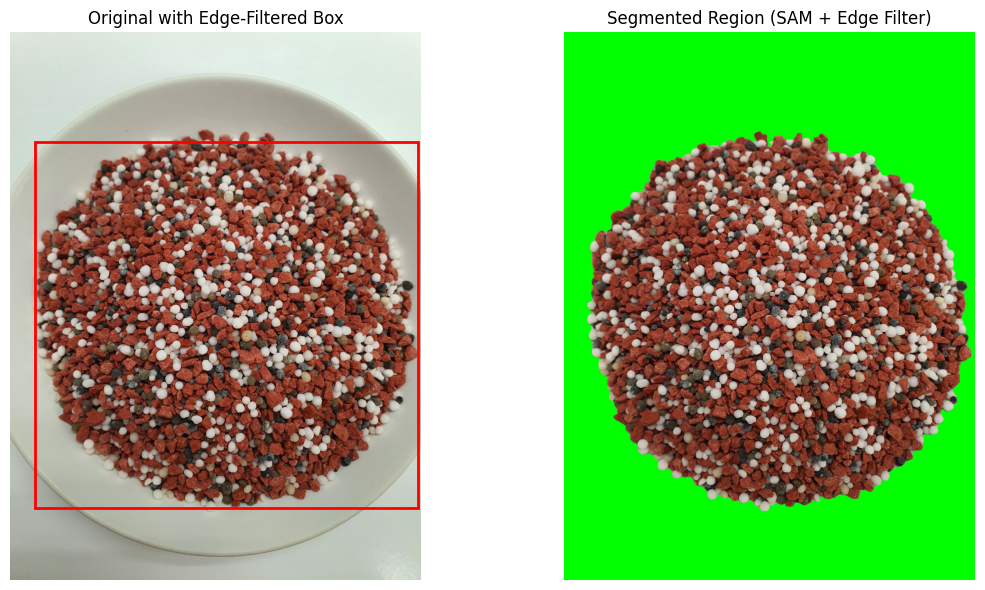

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
from segment_anything import sam_model_registry, SamPredictor

img_path = img_path_list[0][0]  # Your image list

# === Load SAM model ===
sam_checkpoint = "sam_vit_b_01ec64.pth"
model_type = "vit_b"
device = "cuda" if torch.cuda.is_available() else "cpu"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
predictor = SamPredictor(sam)

# === Load image ===
image_bgr = cv2.imread(img_path)
if image_bgr is None:
    raise FileNotFoundError(f"Image not found at: {img_path}")

image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
predictor.set_image(image_rgb)

# === Enhanced Edge-Based Bounding Box ===
gray = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
edges = cv2.Canny(blurred, 30, 100)

# Morphological cleanup
kernel = np.ones((3, 3), np.uint8)
edges = cv2.dilate(edges, kernel, iterations=1)
edges = cv2.erode(edges, kernel, iterations=1)

# Find contours
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Filter out large, small, or border-touching contours
filtered_contours = []
h, w = image_rgb.shape[:2]
for c in contours:
    x, y, cw, ch = cv2.boundingRect(c)
    area = cv2.contourArea(c)
    if area < 500 or area > 0.5 * h * w:
        continue  # Ignore tiny or huge (plate) regions
    if x <= 5 or y <= 5 or x + cw >= w - 5 or y + ch >= h - 5:
        continue  # Likely touching image border (e.g., plate edge)
    filtered_contours.append(c)

if not filtered_contours:
    raise RuntimeError("No valid contours found after edge filtering.")

# Merge filtered grain contours into one box
all_points = np.vstack(filtered_contours)
x, y, cw, ch = cv2.boundingRect(all_points)
input_box = np.array([x, y, x + cw, y + ch])
print(f"Filtered edge-based box: {input_box}")

# === SAM segmentation ===
masks, scores, logits = predictor.predict(
    box=input_box,
    multimask_output=True
)
best_mask = masks[np.argmax(scores)]

# === Visualize ===
masked_image = image_rgb.copy()
masked_image[~best_mask] = [0, 255, 0]  # Show background in green

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(image_rgb)
plt.title("Original with Edge-Filtered Box")
plt.gca().add_patch(plt.Rectangle(
    (input_box[0], input_box[1]),
    input_box[2] - input_box[0],
    input_box[3] - input_box[1],
    edgecolor='red',
    linewidth=2,
    facecolor='none'
))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(masked_image)
plt.title("Segmented Region (SAM + Edge Filter)")
plt.axis('off')

plt.tight_layout()
plt.show()

Enhancing image...
Start: Showing original image...


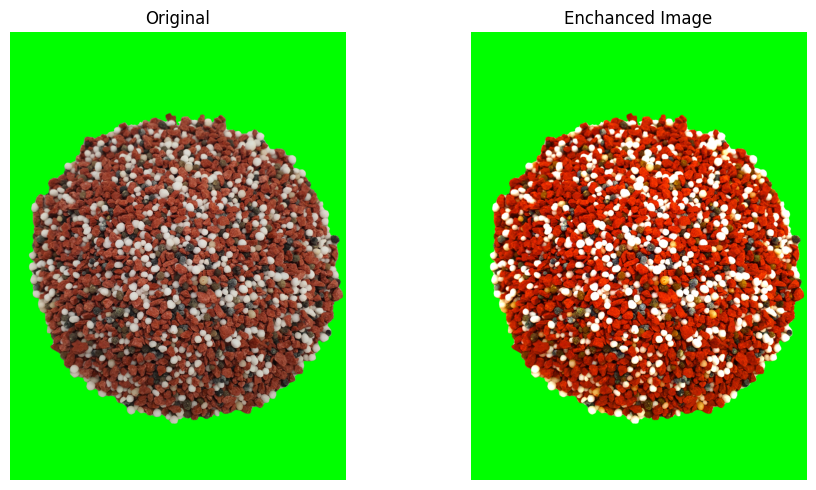

Getting image shape and flattening pixels...
Filtering out pure green pixels...
Running KMeans clustering into 4 clusters...
Preparing valid indices for mapping back...
Processing each cluster to create masks and points...


Clusters:  25%|██▌       | 1/4 [00:02<00:07,  2.38s/it]

Cluster 0: mask created with 1959695 points.


Clusters:  50%|█████     | 2/4 [00:03<00:03,  1.91s/it]

Cluster 1: mask created with 1264653 points.


Clusters:  75%|███████▌  | 3/4 [00:05<00:01,  1.61s/it]

Cluster 2: mask created with 1097936 points.


Clusters: 100%|██████████| 4/4 [00:07<00:00,  1.80s/it]

Cluster 3: mask created with 1693415 points.
Sorting clusters by total RGB brightness...
All clusters processed. Starting visualization...


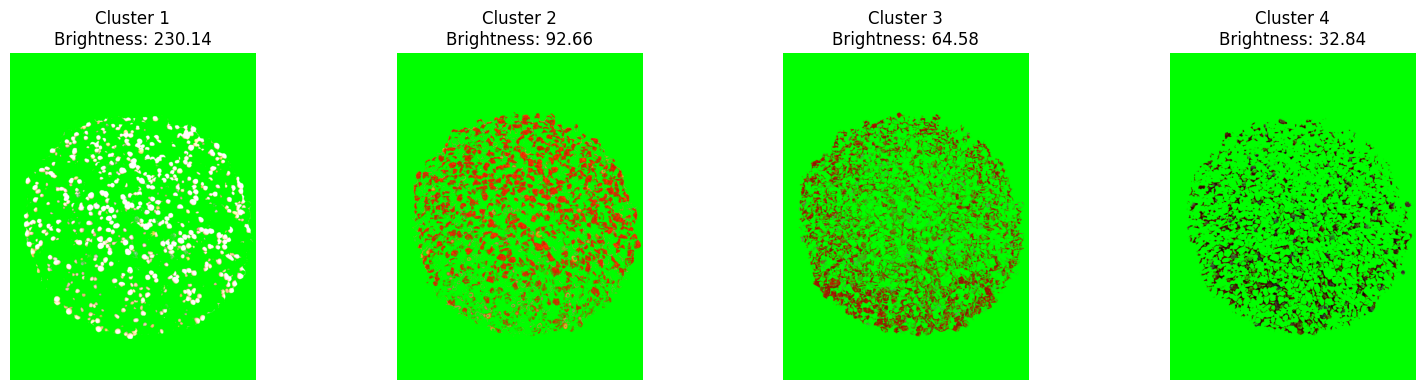

In [3]:
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm  # Progress bar

# === CONFIG ===
BEAD_MASKS = 4             # Number of clusters
CONTRAST_FACTOR = 1.4       # >1 increases contrast
SATURATION_FACTOR = 2.5       # >1 increases vividity
BRIGHTNESS_OFFSET = 0      # Offset for brightness adjustment

# === Image enhancement with comprehensive clipping ===
def enhance_image(image, contrast=CONTRAST_FACTOR, saturation=SATURATION_FACTOR, brightness=BRIGHTNESS_OFFSET):
    # Create a mask for pure green pixels (RGB = [0, 255, 0])
    green_mask = np.all(image == [0, 255, 0], axis=-1)

    # Backup green pixels
    green_pixels = image[green_mask]

    # Ensure input is float32 for precise calculations
    img = np.clip(image.astype(np.float32), 0, 255)

    # Apply contrast with clipping
    img = np.clip(contrast * img, 0, 255)

    # Apply brightness adjustment with clipping
    img = np.clip(img + brightness, 0, 255)

    # Convert to uint8 for HSV conversion
    img_uint8 = img.astype(np.uint8)

    # Convert to HSV and apply saturation boost
    hsv = cv2.cvtColor(img_uint8, cv2.COLOR_RGB2HSV).astype(np.float32)
    hsv[..., 1] = np.clip(hsv[..., 1] * saturation, 0, 255)
    hsv = np.clip(hsv, 0, 255)

    # Convert back to RGB
    enhanced = cv2.cvtColor(hsv.astype(np.uint8), cv2.COLOR_HSV2RGB)
    enhanced = np.clip(enhanced, 0, 255).astype(np.uint8)

    # Restore the original green pixels
    enhanced[green_mask] = green_pixels

    return enhanced



# === Grouping points ===
def get_all_grouped_points(label):
    point_coords = []
    group_indices = np.where(labels == label)[0]
    for indice in group_indices:
        original_flat_index = valid_indices[indice]
        y, x = divmod(original_flat_index, W)
        point_coords.append([x, y])
    return np.array(point_coords)

print("Enhancing image...")
enhanced_image = enhance_image(masked_image)

# === Processing starts here ===
print("Start: Showing original image...")
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(masked_image)
plt.title("Original")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(enhanced_image)
plt.title("Enchanced Image")
plt.axis('off')
plt.tight_layout()
plt.show()

print("Getting image shape and flattening pixels...")
H, W, _ = enhanced_image.shape
pixels = enhanced_image.reshape(-1, 3)

print("Filtering out pure green pixels...")
non_black_indices = np.any(pixels != [0, 255, 0], axis=1)
pixels_non_black = pixels[non_black_indices]

print("Running KMeans clustering into", BEAD_MASKS, "clusters...")
kmeans = KMeans(n_clusters=BEAD_MASKS, random_state=42)
labels = kmeans.fit_predict(pixels_non_black)

print("Preparing valid indices for mapping back...")
valid_indices = np.where(non_black_indices)[0]

all_masks = []
all_point_coords = []

print("Processing each cluster to create masks and points...")
for cluster_label in tqdm(range(BEAD_MASKS), desc="Clusters"):
    mask_flat = np.zeros(H * W, dtype=bool)
    cluster_pixel_indices = valid_indices[labels == cluster_label]
    mask_flat[cluster_pixel_indices] = True
    mask_2d = mask_flat.reshape(H, W)
    point_coords = get_all_grouped_points(cluster_label)
    all_masks.append(mask_2d)
    all_point_coords.append(point_coords)
    print(f"Cluster {cluster_label}: mask created with {len(point_coords)} points.")

print("Sorting clusters by total RGB brightness...")

# Compute average brightness for each mask (proportional, not cumulative)
brightness_averages = []
for mask in all_masks:
    masked_pixels = enhanced_image[mask]  # shape: (N, 3) for RGB
    if len(masked_pixels) == 0:
        brightness = 0  # Avoid division by zero
    else:
        brightness = np.mean(masked_pixels)  # Average brightness
    brightness_averages.append(brightness)


# Get sorted indices from brightest to darkest
sorted_indices = np.argsort(brightness_averages)[::-1]  # Descending order

# Reorder clusters by brightness
all_masks = [all_masks[i] for i in sorted_indices]
all_point_coords = [all_point_coords[i] for i in sorted_indices]

print("All clusters processed. Starting visualization...")

plt.figure(figsize=(16, 4))
for i in range(BEAD_MASKS):
    cluster_img = np.full_like(enhanced_image, fill_value=[0, 255, 0])  # Green background
    mask = all_masks[i]
    cluster_img[mask] = enhanced_image[mask]  # Overlay original colors of cluster

    avg_brightness = brightness_averages[sorted_indices[i]]
    plt.subplot(1, BEAD_MASKS, i + 1)
    plt.imshow(cluster_img)
    plt.title(f"Cluster {i+1}\nBrightness: {avg_brightness:.2f}")
    plt.axis('off')

plt.tight_layout()
plt.show()


Measuring cluster areas: 100%|██████████| 4/4 [00:00<00:00, 57.53it/s]


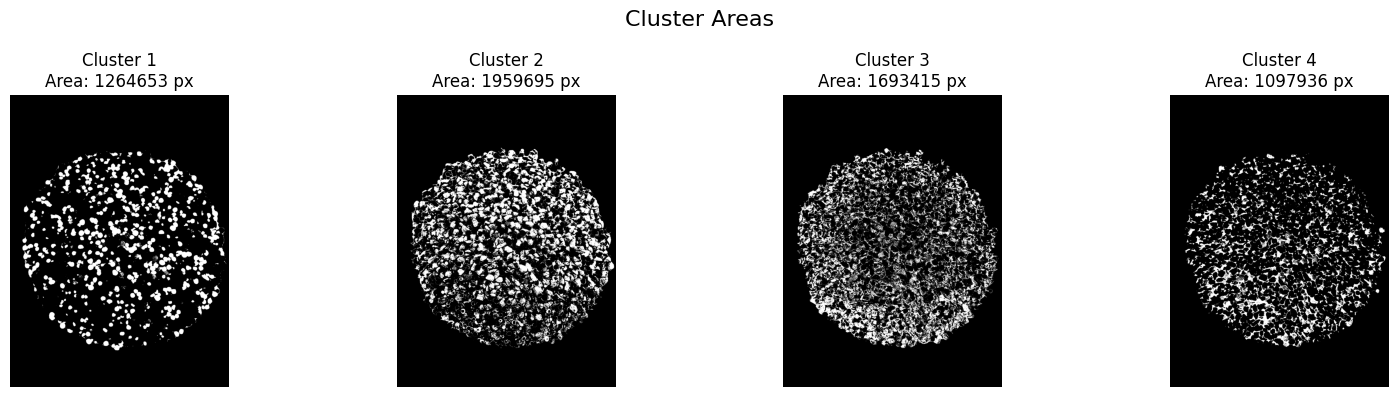


Cluster Area Summary:
Cluster 1: 1264653 pixels
Cluster 2: 1959695 pixels
Cluster 3: 1693415 pixels
Cluster 4: 1097936 pixels
Total Cluster Area: 6015699


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm

# === Assuming `all_masks` is a list of boolean or binary masks (H x W) ===
# all_masks = [...]  # This should already be created before this script runs

# === Compute Cluster Areas ===
cluster_areas = []
for i, mask in enumerate(tqdm(all_masks, desc="Measuring cluster areas")):
    area = np.sum(mask > 0)  # Counts all non-zero (i.e., masked) pixels
    cluster_areas.append(area)

# === Visualization of Mask with Area ===
plt.figure(figsize=(16, 4))
for i, (mask, area) in enumerate(zip(all_masks, cluster_areas)):
    plt.subplot(1, len(all_masks), i + 1)
    plt.imshow(mask, cmap='gray')
    plt.title(f"Cluster {i+1}\nArea: {area} px")
    plt.axis('off')
plt.suptitle("Cluster Areas", fontsize=16)
plt.tight_layout()
plt.show()

# === Print Area Summary ===
print("\nCluster Area Summary:")
for i, area in enumerate(cluster_areas):
    print(f"Cluster {i+1}: {area} pixels")

print("Total Cluster Area:", sum(cluster_areas))


In [ ]:
print(cluster_areas)

[667302, 604464, 2697774, 1649554]


In [5]:
def get_npk(cluster_areas):
    
    shadow_area = 200000  # Area of the shadow

    white_beads = cluster_areas[0]
    stain_beads = cluster_areas[1]
    red_beads = cluster_areas[2]
    black_beads = cluster_areas[3] - shadow_area

    white_composition = {'N': 46, 'P': 0, 'K': 0}
    red_composition   = {'N': 0, 'P': 0, 'K': 60}
    stain_composition = {'N': 21, 'P': 0, 'K': 0}
    black_composition = {'N': 18, 'P': 46, 'K': 0}

    npk_total = {'N': 0, 'P': 0, 'K': 0}

    for key in npk_total:
        npk_total[key] += red_composition[key] * red_beads
        npk_total[key] += white_composition[key] * white_beads
        npk_total[key] += stain_composition[key] * stain_beads
        npk_total[key] += black_composition[key] * black_beads

    total_beads = sum(cluster_areas) - shadow_area
    npk_composition = {key: round(val / total_beads, 2) for key, val in npk_total.items()}
    
    return npk_composition

print(f"NPK Composition: {get_npk(cluster_areas)} in percantage")

NPK Composition: {'N': 19.86, 'P': 7.1, 'K': 17.47} in percantage
